In [1]:
import matlab.engine
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import datetime
from scipy.io import loadmat
from collections import defaultdict

eng = matlab.engine.start_matlab()

In [2]:
year = 2010
month = 1
day = 3
hour = 0
minute = 0
second = 0

startDateMatlab = [year, month, day, hour, minute, second]
endDateMatlab = [year, month, day, hour+23, minute+59, second+59]

startDate = datetime.datetime(year, month, day, hour, minute, second)
endDate = datetime.datetime(year, month, day, hour+23, minute+59, second+59)


stationsWithNoData = []
stationsNonexistentInFolder = []
stationsOut = dict()
dotsX=[]
dotsY=[]
dotsHeights=[]
stationIndicatorVariation = defaultdict(list)

mat = loadmat("../../../../opt/dir.indices/station.mat")

allMatData = mat.get("station", "none")[0]
allStationCodes=[]

for x in allMatData:
    allStationCodes.append(x[1][0])
    

In [3]:
%%time
for st in allStationCodes: 
    try:
        stationsOut[st] = eng.indices_alpha(matlab.double(startDateMatlab), matlab.double(endDateMatlab),str(st))
    except:
        stationsNonexistentInFolder.append(st)

CPU times: user 391 ms, sys: 67.4 ms, total: 459 ms
Wall time: 3.03 s


In [4]:
%%time
from collections import OrderedDict

stationsYearMagPosition = OrderedDict(OrderedDict())
stationPosition = OrderedDict()  

for x in allMatData:  
    stationsYearMagPosition[str(x[1][0])] = OrderedDict()  
    try:
        for i in range(len(x[5][0])):
            stationPosition[x[5][0][i]] = x[9][0][i], x[10][0][i]
            stationsYearMagPosition[str(x[1][0])] = stationPosition.copy()
    except:
        print("no value")

CPU times: user 115 ms, sys: 16.4 ms, total: 131 ms
Wall time: 116 ms


In [5]:
def IndicatorCalculation(dataSt, timeshift, currentDate):
    
    a1=np.float32(dataSt.get("a1")[timeshift])
#     x=np.float32(dataSt.get("x")[timeshift])
    x1=np.float32(dataSt.get("x1")[timeshift])
    x2=np.float32(dataSt.get("x2")[timeshift])
#     x3=np.float32(dataSt.get("x3")[timeshift])
#     x4=np.float32(dataSt.get("x4")[timeshift])
#     y=np.float32(dataSt.get("y")[timeshift])
    y1=np.float32(dataSt.get("y1")[timeshift])
#     y2=np.float32(dataSt.get("y2")[timeshift])
#     y3=np.float32(dataSt.get("y3")[timeshift])
#     y4=np.float32(dataSt.get("y4")[timeshift])
    z1=np.float32(dataSt.get("z1")[timeshift])
    stLongeo=np.float32(dataSt.get("longeo"))
    stLatgeo=np.float32(dataSt.get("latgeo"))
    stAlt=np.float32(dataSt.get("alt"))
    
    currentDateMatlab = [currentDate.year, currentDate.month, currentDate.day, currentDate.hour, currentDate.minute, currentDate.second]
    
    b=eng.igrf(matlab.double([stLongeo]), matlab.double([stLatgeo]), matlab.double([stAlt]), matlab.double([currentDateMatlab]), nargout=4)
    
    ratio = (((math.sqrt(pow(x1, 2)+pow(y1, 2)+pow(z1, 2)))/b[3])-1)*100
    indicator = gaussian(ratio, 1, 0)
    return np.round(a1,10)

In [6]:
from IPython.display import clear_output

def drawMap(timeshift, date):
    clear_output(wait=True)
    plt.clf()
    w = 12
    h = 6
    d = 100
    x = range(360)
    y = range (180)
#     img = plt.imread("map2.png")
    plt.figure(figsize=(w, h), dpi=d)
#     plt.imshow(img, extent=[-180, 180, -90, 90])
    global dotsX
    del dotsX[:]
    global dotsY
    del dotsY[:]
    global dotsHeights
    del dotsHeights[:]
    
    
    for st in allStationCodes:
        if st != "ipm":
            try:
                stationIndicatorVariation[st].append(IndicatorCalculation(stationsOut.get(st), timeshift, date))
                dotsHeights.append(IndicatorCalculation(stationsOut.get(st), timeshift, date))
                if stationsOut.get(st).get("longeo")>180:
                    dotsX.append(stationsOut.get(st).get("longeo")-360)
                else:
                    dotsX.append(stationsOut.get(st).get("longeo"))
                dotsY.append(stationsOut.get(st).get("latgeo"))
            except:
                stationsWithNoData.append(st)
        else:
            None
                
    if not dotsX or not dotsY or not dotsHeights:
        print("No data given! Is the current date out of bounds? Current date: {} __ Max date: {}".format(date, endDate))
    else:
        contourMap()
        plt.colorbar()
        plt.suptitle(str(date), fontsize=14, fontweight='bold')
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.show()

In [7]:
from scipy.interpolate import griddata
import math


def contourMap():
    global dotsX
    global dotsY
    global dotsHeights
    
    for i in range(len(dotsHeights)):
        if math.isnan(dotsHeights[i]): dotsHeights[i]= 0

    xi = np.arange(-180,180,1)
    yi = np.arange(-90,90,1)
    xi,yi = np.meshgrid(xi,yi)

    zi = griddata((dotsX,dotsY),dotsHeights,(xi,yi),method='linear')
    
    plt.contourf(xi,yi,zi,np.arange(min(dotsHeights),max(dotsHeights)+0.1,0.1), cmap = "coolwarm")
    plt.plot(dotsX,dotsY,'k.')

0.985413550645


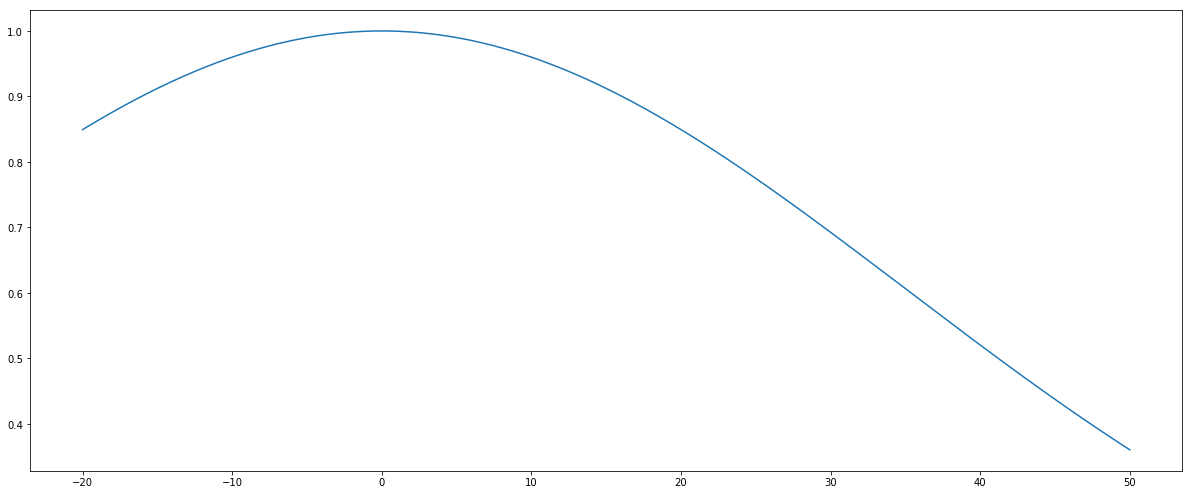

In [78]:
def AbsoluteValue(array):
    return (abs(max(array))+abs(min(array)))/2
def gaussian(x, a, b, c):
    return a*math.exp(-np.power((x-b),2)/(2*np.power(c,2)))

print(gaussian(6, 1, 0, AbsoluteValue(x)))
x = np.linspace(-20, 50, 1000)
fig= plt.figure(figsize=(20,8))
axes= fig.add_axes([0.8,0.8,0.8,0.8])
gauss = np.vectorize(gaussian)

axes.plot(x, gauss(x, 1, 0, AbsoluteValue(x)))
plt.show()

In [291]:
stationIndicatorVariation.clear()
stationName = "clf"
timeBetweenValues = 8
dataResolution = 0

if 360%(1440/timeBetweenValues)==0:
    dataResolution = 360/(1440/timeBetweenValues)
    
    for st in allStationCodes:
        i=0 # En minutes
        delta = endDate-startDate
        totalMinutes = (delta.total_seconds()+1)/60
        while(i<=totalMinutes-1):
                try:
                    update = datetime.timedelta(minutes=i)
                    currentDate = startDate+update
                    stationIndicatorVariation[st].append(float(IndicatorCalculation(stationsOut.get(st), i, currentDate)))
                except:
                    None
                i+=timeBetweenValues
            
else:
    print("!ERROR! -- Your timeBetweenValues must be a multiple of the chosen time delta's amount of minutes -- !ERROR!")
    sys.exit



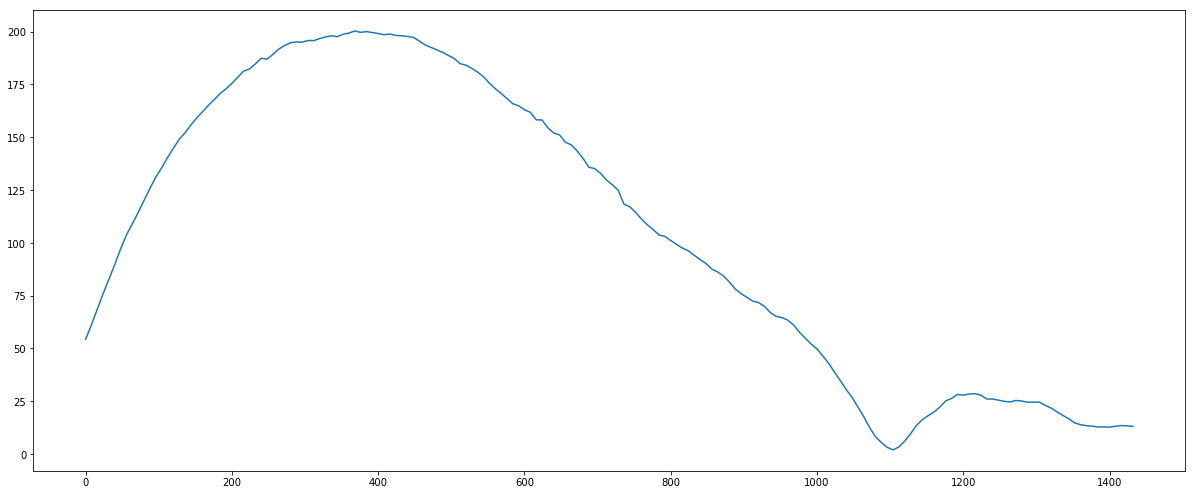

In [292]:
y = np.array(stationIndicatorVariation["ipm"])
x = np.arange(0, i, timeBetweenValues)
fig= plt.figure(figsize=(20,8))
axes= fig.add_axes([0.8,0.8,0.8,0.8])
axes.plot(x,y)
plt.show()

In [11]:
from IPython.display import display
import ipywidgets as widgets

time=0
timeshift=60


upButton = widgets.Button(description="+{} minute(s)".format(timeshift))
downButton = widgets.Button(description="-{} minute(s)".format(timeshift))
output = widgets.Output()

def on_upButton_clicked(b):
    global timeshift
    global time
    global startDate
    time+=timeshift
    update = datetime.timedelta(minutes=time)
    currentDate = startDate+update
    with output:
        drawMap(time, currentDate);

upButton.on_click(on_upButton_clicked)


def on_downButton_clicked(b):
    global timeshift
    global time
    global startDate
    time-=timeshift
    update = datetime.timedelta(minutes=time)
    currentDate = startDate+update
    with output:
        drawMap(time, currentDate);

downButton.on_click(on_downButton_clicked)



buttons = widgets.HBox([downButton, upButton])
widgets.VBox([buttons, output])

VkJveChjaGlsZHJlbj0oSEJveChjaGlsZHJlbj0oQnV0dG9uKGRlc2NyaXB0aW9uPXUnLTYwIG1pbnV0ZShzKScsIHN0eWxlPUJ1dHRvblN0eWxlKCkpLCBCdXR0b24oZGVzY3JpcHRpb249dSfigKY=


In [293]:
def AdaptDimensions(vector):
    outputVector=np.array([])
    shift=360/vector.shape[0]
    for y in range(0, vector.shape[0]):
        for i in range(0, shift):
            outputVector = np.append(outputVector, vector[y])
    return outputVector

In [399]:
indicatorVariationArray = np.full((180, 360), np.inf)
for st in allStationCodes:
    for i in range(-90, 90):
        try:
            if i == np.round(np.int16(stationsOut[st].get("latgeo")),0):
                indicatorVariationArray[i]=AdaptDimensions(np.array(stationIndicatorVariation[st]))
            else:
                None
        except:
            None

In [87]:
y_true = np.empty_like(indicatorVariationArray[64])
y_true[:] = indicatorVariationArray[64]

In [95]:
from sklearn.metrics import accuracy_score

indicatorVariationArray[64] = np.full(360, np.nan)
a = svr_rbf.score(y_true.reshape(360,1), PredictIndicatorThroughTime(64).reshape(360,1))
print(a)

/home/cristille/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()
/home/cristille/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  if sys.path[0] == '':


-0.889750890156698


In [167]:
%%time
def PredictIndicatorThroughTime(wantedLatitude):
    timePrediction = np.full((360), np.inf)
    for i in range(0, 360, dataResolution):
        result = GetIndicatorLongPrediction(wantedLatitude,i)
        for y in range(i,i+dataResolution):
            timePrediction[y] = result
    return timePrediction

def AddTimePredictionToGlobal(prediction, latitude):
    indicatorVariationArray[latitude] = prediction
    
# AddTimePredictionToGlobal(PredictIndicatorThroughTime(90), 90)

CPU times: user 29 µs, sys: 1e+03 ns, total: 30 µs
Wall time: 45.1 µs


In [407]:
%time
def PredictIndicatorForAllLatitudes():
    for i in range(0,180):
        specificLatitudeTimePrediction = np.full((360), np.inf)
        if math.isinf(indicatorVariationArray[i][0]) or math.isnan(indicatorVariationArray[i][0]):
            for y in range(0,360,dataResolution):
                result = GetIndicatorLongPrediction(i,y)
                for t in range(y,y+dataResolution):
                    specificLatitudeTimePrediction[t] = result
            indicatorVariationArray[i] = specificLatitudeTimePrediction

PredictIndicatorForAllLatitudes()

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 14.1 µs


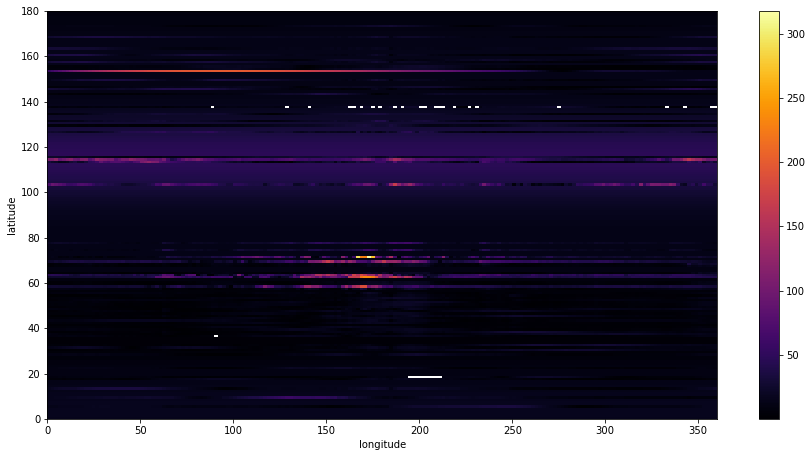

In [408]:
fig= plt.figure(figsize=(15,7.5))
plt.imshow(indicatorVariationArray, origin='lower', cmap=plt.get_cmap("inferno"), aspect='auto', extent=[0,360,0,180])
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.colorbar()
plt.show()

In [108]:
savedAllPredictionsArray = np.empty_like(indicatorVariationArray) 
savedAllPredictionsArray[:] = indicatorVariationArray 

In [296]:
def GetIndicatorLongPrediction(latitude, longitude):
    indicatorLatVariation = np.array([])
    for i in range(0, 180):
        indicatorLatVariation = np.append(indicatorLatVariation, indicatorVariationArray[i][longitude])

    y = np.array(indicatorLatVariation)
    x = np.arange(0, 180, 1)
    return SupportVectorRegression(x,y).predict(latitude)

In [413]:
from sklearn.svm import SVR

def SupportVectorRegression(latValues, indicatorValues):
    svr_rbf = SVR(kernel='rbf', C=100, gamma=0.001)
    SVRmodel = svr_rbf.fit(x, y)
    
    return SVRmodel


def RemoveInfNan(latValues, indicatorValues):
    indexDeleteY = np.array([])
    for i in range(0, indicatorValues.shape[0]):
        if math.isinf(indicatorValues[i]) or math.isnan(indicatorValues[i]):
            indexDeleteY = np.append(indexDeleteY, i)
    newY = np.delete(indicatorValues, indexDeleteY)
    newX = np.delete(latValues, indexDeleteY)
    newY=newY.reshape(newY.shape[0],1)
    newX=newX.reshape(newY.shape[0],1)
    
    return newX, newY

/home/cristille/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  from ipykernel import kernelapp as app
/home/cristille/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  app.launch_new_instance()


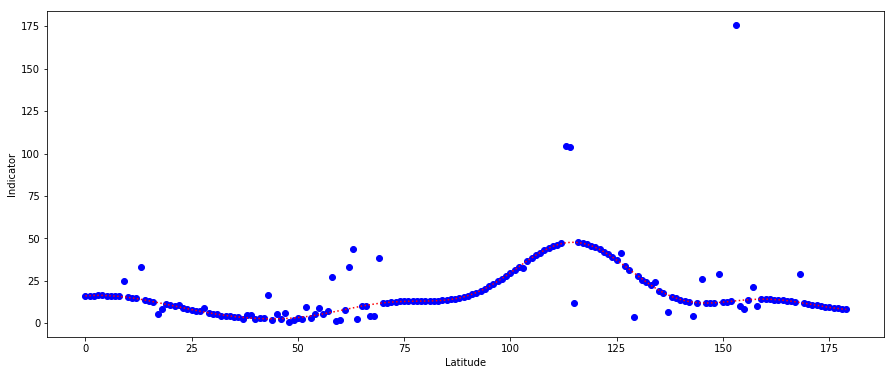

In [414]:
indicatorLatVariation = np.array([])
for i in range(0, 180):
    indicatorLatVariation = np.append(indicatorLatVariation, indicatorVariationArray[i][50])

y = np.array(indicatorLatVariation)
x = np.arange(0, 180, 1)

plt.figure(figsize=(15,6))
plt.xlabel("Latitude")
plt.ylabel("Indicator")
plt.scatter(x, y, c = 'blue')

x, y = RemoveInfNan(x, y)
plt.plot(x, SupportVectorRegression(x,y).predict(x), "r:")
plt.show()

In [383]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0)

parameters = [{'kernel': ['rbf'], 'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],'C': [1, 10, 100, 1000, 10000]}]


In [398]:
from sklearn.metrics import r2_score

print("# Tuning hyper-parameters")
scorer = make_scorer(mean_squared_error, greater_is_better=False)
svr = GridSearchCV(SVR(), parameters, cv = K, scoring=scorer)
svr.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(svr.best_params_)

print("Grid scores on development set:")
means = svr.cv_results_['mean_test_score']
stds = svr.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, svr.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

print("Detailed classification report:")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
y_true, y_pred = y_test, svr.predict(X_test)
print(r2_score(y_true, y_pred))

# Tuning hyper-parameters
Best parameters set found on development set:
{'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}
Grid scores on development set:
-1278.345 (+/-3086.297) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
-1262.771 (+/-3055.572) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
-1284.293 (+/-3088.045) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.01}
-1293.874 (+/-3113.547) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.1}
-1294.275 (+/-3116.472) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.2}
-1294.375 (+/-3118.432) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.5}
-1294.591 (+/-3119.124) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.6}
-1295.294 (+/-3120.538) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.9}
-1203.719 (+/-2745.579) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
-1208.247 (+/-2869.222) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
-1272.114 (+/-2967.457) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.01}
-1312.767 (+/-3074.087) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.1}
-1300.100 (+/-3077.

In [395]:
a = 30
print(y_true[a], y_pred[a])

(array([14.28446293]), 20.938156925020778)


In [327]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)

# Loading the Digits dataset
digits = datasets.load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.



Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision
()
Best parameters set found on development set:
()
{'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
()
Grid scores on development set:
()
0.983 (+/-0.015) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
0.956 (+/-0.027) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
0.985 (+/-0.014) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
0.981 (+/-0.020) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
0.985 (+/-0.014) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.001}
0.981 (+/-0.019) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}
0.985 (+/-0.014) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
0.981 (+/-0.019) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.0001}
0.976 (+/-0.002) for {'kernel': 'linear', 'C': 1}
0.976 (+/-0.002) for {'kernel': 'linear', 'C': 10}
0.976 (+/-0.002) for {'kernel': 'linear', 'C': 100}
0.976 (+/-0.002) for {'kernel': 'linear', 'C': 1000}
()
Detailed classification report:
(

In [99]:
from IPython.display import clear_output

def drawMapForAnimation(timeshift, date):
    clear_output(wait=True)
    plt.clf()
    global dotsX
    del dotsX[:]
    global dotsY
    del dotsY[:]
    global dotsHeights
    del dotsHeights[:]
    global startDate
    
    for st in allStationCodes:
        if st != "ipm":
            try:
                update = datetime.timedelta(minutes=timeshift)
                currentDate = startDate+update
                dotsHeights.append(IndicatorCalculation(stationsOut.get(st), timeshift, currentDate))   
                if stationsOut.get(st).get("longeo")>180:
                    dotsX.append(stationsOut.get(st).get("longeo")-360)
                else:
                    dotsX.append(stationsOut.get(st).get("longeo"))
                dotsY.append(stationsOut.get(st).get("latgeo"))
            except:
                stationsWithNoData.append(st)
        else:
            None      
    if not dotsX or not dotsY or not dotsHeights:
        print("No data given! Is the current date out of bounds? Current date: {} __ Max date: {}".format(date, endDate))
    else:
        contourMap()
        plt.colorbar()
        update = datetime.timedelta(minutes=timeshift)
        currentDate = startDate+update
        plt.suptitle(str(currentDate), fontsize=14, fontweight='bold')

IndexError: list index out of range

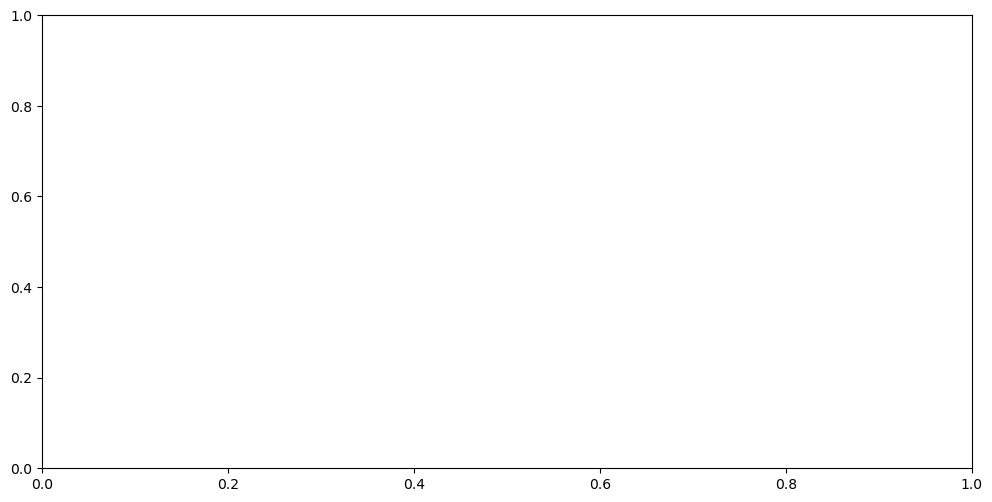

In [102]:
import matplotlib.animation as manimation

def MakeAnimation():
    FFMpegWriter = manimation.writers['html']
    writer = FFMpegWriter(fps=15)
    fig = plt.figure(figsize=(12, 6), dpi=100)
    
    plt.xlabel('longitude')
    plt.ylabel('latitude')

    plt.xlim(-180, 180)
    plt.ylim(-90, 90)

    i=0 # En minutes
    delta = endDate-startDate
    with writer.saving(fig, "../Documents/Animations/MagneticVariationsAnimation/MagneticVariationsAnimation.html", 100):
        while(i<=(delta.total_seconds()+1)/60):
            drawMapForAnimation(i, startDate)
            writer.grab_frame()
            i+=60
            
MakeAnimation()
